<a href="https://colab.research.google.com/github/betsenara/Sentiment-Analysis-for-Mental-Health/blob/main/data_wrangling_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
!pip install langdetect
from langdetect import detect

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import os
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Mental Health Sensitivity Analysis'

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Change to the desired directory in Google Drive
os.chdir('/content/drive/My Drive/Colab Notebooks/Mental Health Sensitivity Analysis')

# Verify by listing files in the current directory
print(os.listdir())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['data_clean.csv', 'word2vec_model.model', 'BaseModel', 'Data.csv', 'data_wrangling_eda.ipynb']


In [ ]:
#Read data
# encoding='ISO-8859-1'
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Mental Health Sensitivity Analysis/Data.csv', encoding='latin-1')

In [ ]:
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
data.shape

(53043, 3)

Check if each post belongs to a different person with different id:

In [ ]:
data['Unnamed: 0'].nunique()

53043

We can drop the column 'Unnamed: 0' since it doesn't give extra information.

In [ ]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
data.isna().sum()

,0
statement,362
status,0


The rows with null values can be dropped.

In [ ]:
data.dropna(inplace=True)

### Duplicates

Check if the statements are unique.

In [ ]:
data[['statement','status']].nunique()

,0
statement,51073
status,7


In [ ]:
# the statements that are not unique:
data.loc[data['statement'].duplicated(keep=False),['statement','status']]

,statement,status
18,"""No regrets or grudges/angry at things that ha...",Anxiety
39,but my heart is still restless even though my ...,Anxiety
97,"""No regrets or grudges/angry at things that ha...",Anxiety
132,I want to exhale the restlessness in my chest ...,Anxiety
138,but my heart is still restless even though my ...,Anxiety
...,...,...
53038,Nobody takes me seriously Iâve (24M) dealt w...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [ ]:
data.drop_duplicates(subset='statement',inplace = True)

In [ ]:
print(f'There are {data.shape[0]} unique values in the data.')

There are 51073 unique values in the data.


### Language Detection

After preprocessing, we found that some posts in the data are not in English. We will remove the rows containing non-English statements.

In [ ]:
# Function to detect the language
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

# Apply the function to each row
data['language'] = data['statement'].apply(detect_language)

# Filter rows that are not in English
non_english_rows = data[data['language'] != 'en']
print(len(non_english_rows))

2769


In [ ]:
# Drop the data in other languages
data.drop(non_english_rows.index, inplace=True)

In [ ]:
print(f'There are {len(non_english_rows)} non-English rows. After dropping them, the shape of our dataframe is {data.shape}.')

There are 2769 non-English rows. After dropping them, the shape of our dataframe is (48304, 3).


In [ ]:
data.drop('language', axis=1, inplace=True)

### Feature Extraction

We add a column that contains the number of words in the 'statement' column.

In [ ]:
data['word_count'] = data['statement'].apply(lambda x: len(x.split()))

The statistics for that column are as follows:

In [ ]:
data['word_count'].describe()

,word_count
count,48304.000000
mean,118.634295
std,166.548841
min,1.000000
25%,19.000000
50%,68.000000
75%,154.000000
max,6300.000000


In [ ]:
data.loc[data['word_count']<3,'statement']

,statement
88,Anxious
332,Waiting anxiously
343,very restless
376,Restless tonight
424,anxious
...,...
44908,office time
44926,be offline
44959,horrible weather
44964,shattered


In [ ]:
print(f'There are {data.loc[data["word_count"] < 3].shape[0]} rows with statements containing one or two words.')

There are 234 rows with statements containing one or two words.


### Value Counts: Number of Rows per Class

In [ ]:
data['status'].value_counts()

,count
status,
Depression,14856
Normal,13641
Suicidal,10553
Anxiety,3571
Bipolar,2501
Stress,2289
Personality disorder,893


There is class imbalance. We will apply oversampling.

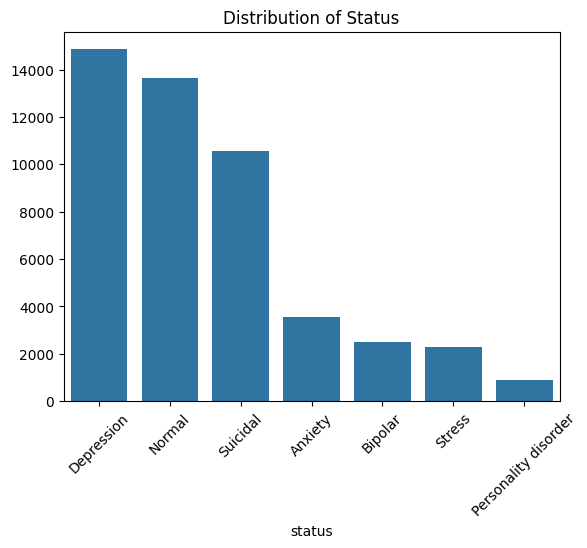

In [ ]:
sns.barplot(x=data['status'].value_counts().index, y=data['status'].value_counts().values)
plt.title('Distribution of Status')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.show()

### Word Count Statistics per Class

In [ ]:
data.groupby('status')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
Anxiety,3571.0,144.872025,152.268027,1.0,43.0,104.0,193.0,1592.0
Bipolar,2501.0,178.276689,180.933365,4.0,74.0,130.0,222.0,4804.0
Depression,14856.0,170.250404,188.622706,2.0,56.0,115.0,218.0,4239.0
Normal,13641.0,19.569753,24.001090,1.0,7.0,11.0,20.0,255.0
Personality disorder,893.0,178.237402,233.190293,5.0,65.0,133.0,234.0,5419.0
Stress,2289.0,111.935780,101.174928,3.0,65.0,86.0,122.0,1606.0
Suicidal,10553.0,147.420165,187.283564,2.0,43.0,93.0,187.0,6300.0


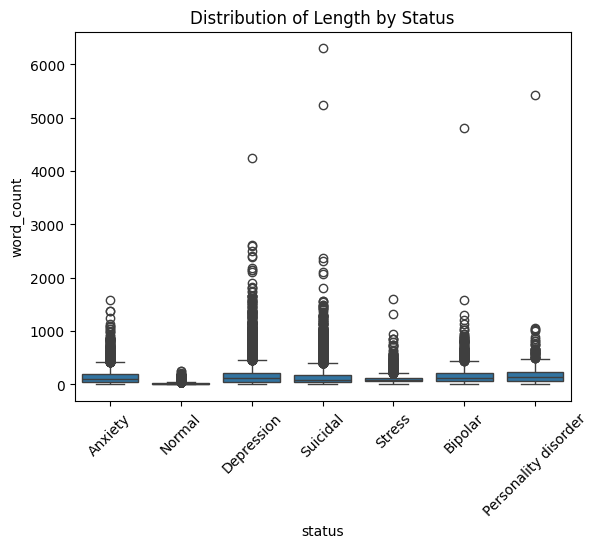

In [ ]:
# Visualise the distribution of word count for all classes:
sns.boxplot(x='status', y='word_count', data=data)
plt.title('Distribution of Length by Status')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.show()

In [ ]:
avg_word_count = data.groupby('status')['word_count'].mean().reset_index()
fig = px.bar(avg_word_count, x='status', y='word_count',
             color='status', title="Average Word Counts Across Classes")
fig.show()


If we look at the graphs showing both the distribution and average word counts across different classes, we can see that people tagged as "normal" have much shorter posts compared to those tagged with a mental health condition. Although the "stress" group has longer posts than the normal group, it is the closest in length to the normal group compared to the other conditions. All other conditions show noticeably longer posts. There are some outliers and exteme values in word length:

In [ ]:
# Print some of the long statements to get an idea of outliers:
for index, row in data.loc[data['word_count'] > 4000].iterrows():
    print(f"Row {index}: {row['statement']}\n")

Row 10834: I have only 1 person I can somewhat open to but I have only done so to a certain extent and try to refrain from doing it at all for the most part. I feel guilty as if I am bothering them with unfairly dumping my bullshit onto them and as if I am doing it for attention or pity. I honestly have no clue how long this will end up being. Whether this story grosses you out, makes you hate me, or even if you choose not to read it, everything is fine with me. It does not really have a point. I just felt like Id never actually let my thoughts out properly and so this is my trashbin.Was raised in a single mother household and never knew my father. Mother divorced him for being psychotic and threatening not only her life but the lives of his children as well. This was after years of her holding out believing it was her duty to sacrifice herself to let her children have a financially stable home with 2 parents. We ended up in a very low class town with minimal income but my mother worke

Row 13293 repeats the same sentence over and over again. So we will change it to once.

In [ ]:
data.loc[13293,'statement'] = 'I cannot TAKE IT ANYMORE.'

The following row contains text that appears to be primarily biblical verses. It will be removed as part of our data cleaning process.



In [ ]:
text_to_find = 'Jesus taught avoidance'
matching_rows = data.loc[data['statement'].str.contains(text_to_find, case=False, na=False)]
matching_rows

,statement,status,word_count
51019,Jesus taught avoidance I'm certain I'd be diag...,Personality disorder,409


In [ ]:
data.loc[51019,'statement']

"Jesus taught avoidance I'm certain I'd be diagnosed with this disorder, and many prophets would too.\n\nJohn the Baptist, for example, lived in the wilderness until he started his ministry. Now that is dedication!\n\nThere are many verses related to AvPD in the Bible, I'll post some at the bottom.\n\nI avoid everyone but Jesus, because he is infinitely loving and wise, and talking to other people is TORTURE in comparison.\n\nI've experienced this phenomenon in my life many times, and I see it constantly across every facet of life - friend groups, businesses, etc\n\nIf a kingdom is divided against itself, that kingdom cannot stand.\n\r\n- Mark 3:24\n\nIt seems that we have realized no matter who or what we come into contact with, it's only a matter of time until it falls apart.\n\nI would argue this is not a disorder, but wisdom.\n\nIn fact, I would encourage everyone to lean into this!\n\nWhatever can be shaken, let it fall.\n\nJesus Christ is the only solid foundation. He is the only

In [ ]:
data.drop(51019,inplace=True)
data.reset_index(drop=True, inplace=True)

## Cleaning the Corpus

The statements will be converted to lowercase and then cleaned by removing symbols, URLs, emojis, and alphanumeric characters.

In [ ]:
def text_clean(text):
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"  # Enclosed Characters
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'',text)
    text = text.lower()
    text = re.sub(r'\S+@\S+','',text) # removing emails from text
    text = re.sub(r'https?://\S+|www\.\S+','',text) # removing urls from text
    text = re.sub(r'\d+','',text) # removing numbers from text
    text = re.sub(r'[^\w\s]','',text)  # removing all alphanumeric values from text
    text = text.strip() # removing leading and trailing whitespaces
    text = remove_emoji(text) #removing emojis from text
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # removing punctuation
    text = re.sub('\n', '', text) # removing newline characters
    text = re.sub(r'@\w+', '', text) # removing usernames in tweets (some posts include tweets)

    return text

Tokenization, stemming, and lemmatization will be performed as follows.

In [ ]:
stop_words=set(stopwords.words('english'))

def text_preprocess(text):
    # Initialize stemmer and lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Remove non-alphabetic characters and short tokens
    tokens = [word for word in tokens if word.isalpha() and len(word) > 1]

    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    # Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Return the cleaned, stemmed, and lemmatized tokens
    return {
        'original': tokens,
        'stemmed': stemmed_tokens,
        'lemmatized': lemmatized_tokens
    }

In [ ]:
def clean_and_preprocess(df):
    df['statement_cleaned'] = df['statement'].apply(text_clean)
    df['stemmed'] = df['statement_cleaned'].apply(lambda x:text_preprocess(x)['stemmed'])
    df['lemmatized'] = df['statement_cleaned'].apply(lambda x:text_preprocess(x)['lemmatized'])
    return df

In [ ]:
# clean and preprocess the data
data = clean_and_preprocess(data)

In [ ]:
data.head()

,statement,status,word_count,statement_cleaned,stemmed,lemmatized
0,"trouble sleeping, confused mind, restless hear...",Anxiety,10,trouble sleeping confused mind restless heart ...,"[troubl, sleep, confus, mind, restless, heart,...","[trouble, sleeping, confused, mind, restless, ..."
1,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,all wrong back off dear forward doubt stay in ...,"[wrong, back, dear, forward, doubt, stay, rest...","[wrong, back, dear, forward, doubt, stay, rest..."
2,I've shifted my focus to something else but I'...,Anxiety,11,ive shifted my focus to something else but im ...,"[ive, shift, focu, someth, els, im, still, worri]","[ive, shifted, focus, something, else, im, sti..."
3,"I'm restless and restless, it's been a month n...",Anxiety,14,im restless and restless its been a month now ...,"[im, restless, restless, month, boy, mean]","[im, restless, restless, month, boy, mean]"
4,"every break, you must be nervous, like somethi...",Anxiety,14,every break you must be nervous like something...,"[everi, break, must, nervou, like, someth, wro...","[every, break, must, nervous, like, something,..."


## Explanatory Data Analysis After Preprocessing

### Word Count After Lemmatization

In [ ]:
data['lemmetized_word_counts'] = data['lemmatized'].apply(len)

In [ ]:
data['lemmetized_word_counts'].describe()

,lemmetized_word_counts
count,48303.000000
mean,53.371799
std,72.775518
min,0.000000
25%,10.000000
50%,31.000000
75%,69.000000
max,2400.000000


The minimum word count has dropped to zero, indicating that some terms were removed during the cleaning process. We will investigate the number of these terms and eliminate them.

In [ ]:
data.loc[data['lemmetized_word_counts']==0,['statement','lemmatized']]

,statement,lemmatized
675,What should I do :-(,[]
1543,where are you?,[]
1926,Where is this,[]
2139,what to do,[]
2199,What should we do,[]
2254,but how can you,[]
2797,then what are you doing now,[]
3115,can this be 2M,[]
3150,So this is it,[]
3344,Why are you?,[]


We observed that questions providing no information about sentiment have been eliminated during the lemmatization process. There are 88 such rows, which will be removed.

In [ ]:
len(data.loc[data['lemmetized_word_counts']==0,'lemmatized'])

53

In [ ]:
# Drop the rows with no words left after lemmetization
data.drop(data.loc[data['lemmetized_word_counts']==0].index, inplace=True)

### Most Common Words in the Corpus

In [ ]:
from collections import Counter
top_words = Counter([word for row in data['lemmatized'] for word in row])

In [ ]:
df_words = pd.DataFrame(top_words.most_common(40),columns=['words','count']).reset_index(drop=True)
df_words.style.hide(axis="index")
df_words.style.background_gradient(cmap='Blues')

,words,count
0,like,36906
1,feel,34255
2,want,27787
3,know,23625
4,life,22382
5,get,22314
6,time,20348
7,even,18046
8,would,16323
9,people,16173


In [ ]:
px.treemap(df_words, path=['words'], values='count', title='Most Common Words in the Corpus')

In [ ]:
pip install wordcloud matplotlib

In [ ]:
from wordcloud import WordCloud

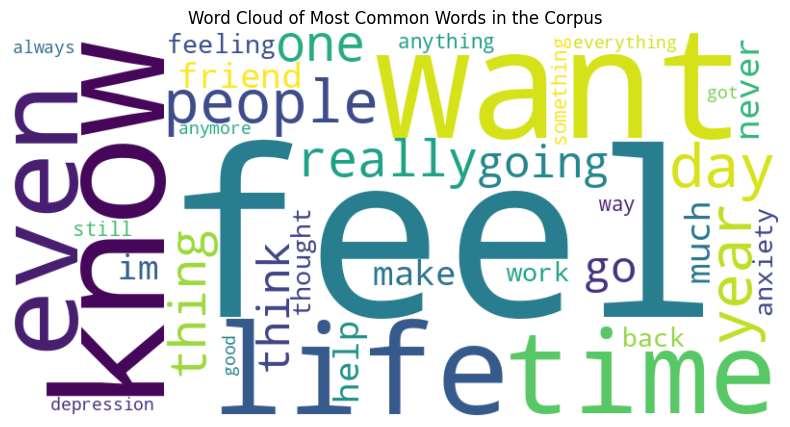

In [ ]:
# Create a WordCloud object
words_all_corpus = ' '.join(df_words['words'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_all_corpus)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Most Common Words in the Corpus')
plt.show()

## Most Common Words in Posts Tagged with Normal




In [ ]:
top_words_normal = Counter([word for row in data.loc[data['status']=='Normal','lemmatized'] for word in row])
df_words_normal = pd.DataFrame(top_words_normal.most_common(20),columns=['words','count']).reset_index(drop=True)
df_words_normal.style.hide(axis="index")
df_words_normal.style.background_gradient(cmap='Blues')

,words,count
0,im,1222
1,want,1176
2,like,1147
3,time,894
4,dont,866
5,get,864
6,really,840
7,one,775
8,know,763
9,go,745


In [ ]:
px.bar(df_words_normal, x='count', y='words',
       color='words', orientation='h',
       title='Most Common Words in Posts Tagged with Normal')

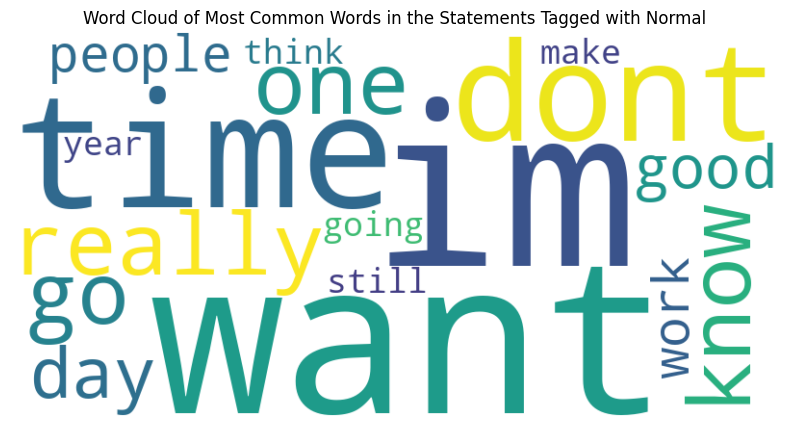

In [ ]:
# Create a WordCloud object
words_normal = ' '.join(df_words_normal['words'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_normal)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Most Common Words in the Statements Tagged with Normal')
plt.show()

## Most Common Words in Posts Tagged with Depression




In [ ]:
top_words_depression = Counter([word for row in data.loc[data['status']=='Depression','lemmatized'] for word in row])
df_words_depression = pd.DataFrame(top_words_depression.most_common(20),columns=['words','count']).reset_index(drop=True)
df_words_depression.style.hide(axis="index")
df_words_depression.style.background_gradient(cmap='Blues')

,words,count
0,like,17983
1,feel,17875
2,want,12459
3,life,11256
4,know,10955
5,get,10377
6,time,9305
7,even,8971
8,people,7789
9,thing,7629


In [ ]:
px.bar(df_words_depression, x='count', y='words',
       color='words', orientation='h',
       title='Most Common Words in Posts Tagged with Depression')

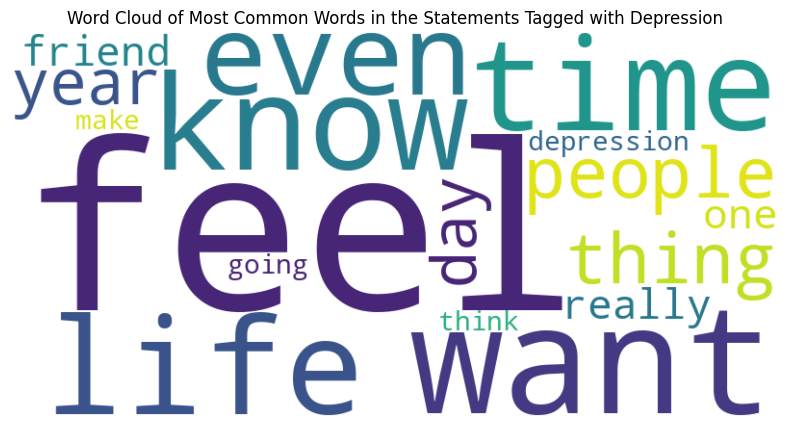

In [ ]:
# Create a WordCloud object
words_depression = ' '.join(df_words_depression['words'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_depression)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Most Common Words in the Statements Tagged with Depression')
plt.show()

We see that the words 'feel' and 'feeling' are considered separate words. To eliminate such words we will use 'stemmed' column instead of 'lemmatized' for similar analysis.

## Most Common Words in the Corpus (Using 'stemmed' Column)

In [ ]:
#from collections import Counter
top_words = Counter([word for row in data['stemmed'] for word in row])

In [ ]:
df_words = pd.DataFrame(top_words.most_common(20),columns=['words','count']).reset_index(drop=True)
df_words.style.hide(axis="index")
df_words.style.background_gradient(cmap='Blues')

,words,count
0,feel,43693
1,like,37951
2,want,32534
3,get,28197
4,go,25407
5,know,24708
6,life,21531
7,time,20388
8,even,18268
9,think,16987


In [ ]:
px.treemap(df_words, path=['words'], values='count', title='Most Common Words in the Corpus(stemmed)')

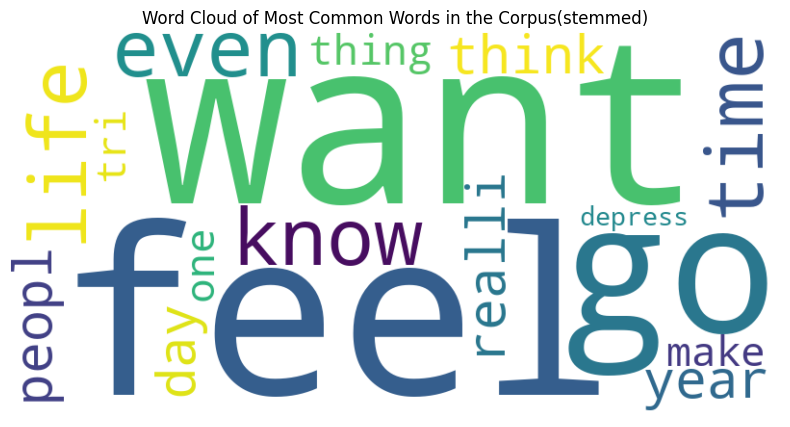

In [ ]:
# Create a WordCloud object
words_all_corpus = ' '.join(df_words['words'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_all_corpus)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Most Common Words in the Corpus(stemmed)')
plt.show()

## Most Common Words in Posts Tagged as Normal (Using 'stemmed' Column)


In [ ]:
top_words_normal = Counter([word for row in data.loc[data['status']=='Normal','stemmed'] for word in row])
df_words_normal = pd.DataFrame(top_words_normal.most_common(20),columns=['words','count']).reset_index(drop=True)
df_words_normal.style.hide(axis="index")
df_words_normal.style.background_gradient(cmap='Blues')

,words,count
0,want,1339
1,go,1242
2,im,1222
3,like,1197
4,get,1059
5,time,897
6,dont,866
7,realli,840
8,one,775
9,know,774


In [ ]:
px.bar(df_words_normal, x='count', y='words',
       color='words', orientation='h',
       title='Most Common Words in Posts Tagged with Normal(stemmed)')

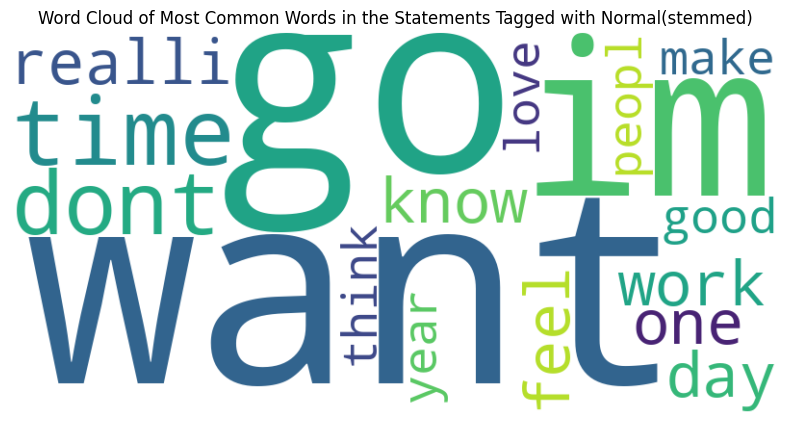

In [ ]:
# Create a WordCloud object
words_normal = ' '.join(df_words_normal['words'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_normal)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Most Common Words in the Statements Tagged with Normal(stemmed)')
plt.show()

## Most Common Words in Posts Tagged with Depression (Using 'stemmed' Column)

In [ ]:
top_words_depression = Counter([word for row in data.loc[data['status']=='Depression','stemmed'] for word in row])
df_words_depression = pd.DataFrame(top_words_depression.most_common(20),columns=['words','count']).reset_index(drop=True)
df_words_depression.style.hide(axis="index")
df_words_depression.style.background_gradient(cmap='Blues')

,words,count
0,feel,22507
1,like,18402
2,want,14645
3,get,12958
4,know,11443
5,go,11062
6,life,10873
7,depress,9774
8,time,9322
9,even,9058


In [ ]:
px.bar(df_words_depression, x='count', y='words',
       color='words', orientation='h',
       title='Most Common Words in Posts Tagged with Depression(stemmed)')

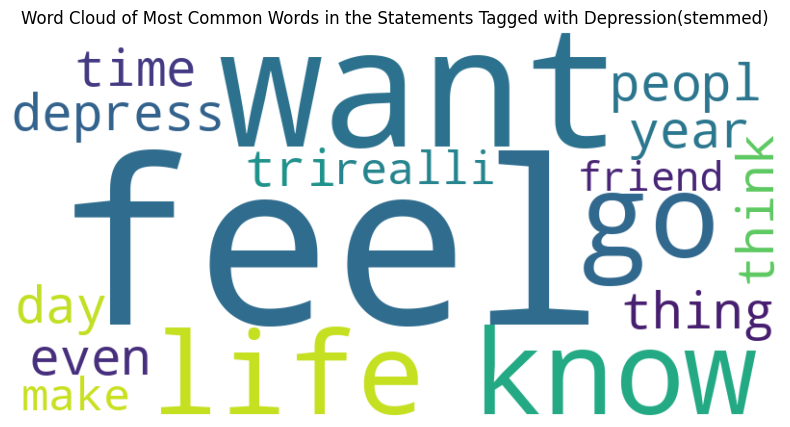

In [ ]:
# Create a WordCloud object
words_depression = ' '.join(df_words_depression['words'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_depression)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Most Common Words in the Statements Tagged with Depression(stemmed)')
plt.show()

Word Clouds for the remaining classes:

In [ ]:
def createWordCloud(data,status):
  top_words = Counter([word for row in data.loc[data['status']==status,'stemmed'] for word in row])
  df_words = pd.DataFrame(top_words.most_common(20),columns=['words','count']).reset_index(drop=True)
  #df_words.style.hide(axis="index")
  #df_words.style.background_gradient(cmap='Blues')
  # Create a WordCloud object
  words = ' '.join(df_words['words'])
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

  # Display the word cloud using matplotlib
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')  # Hide the axes
  plt.title(f'Word Cloud of Most Common Words in the Statements Tagged with {status}(stemmed)')
  plt.show()

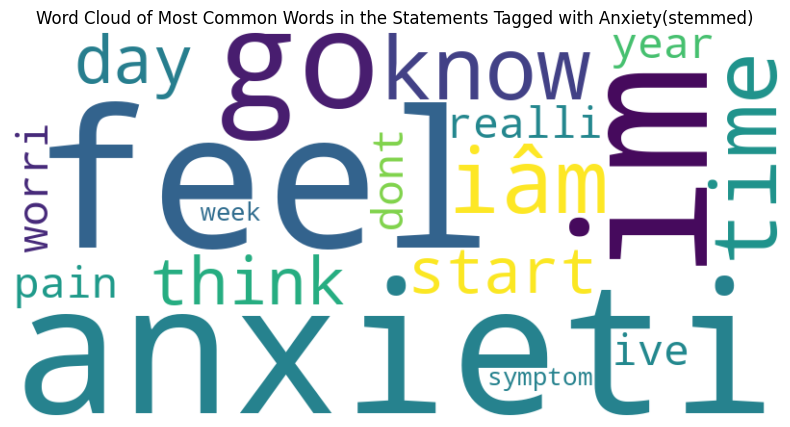

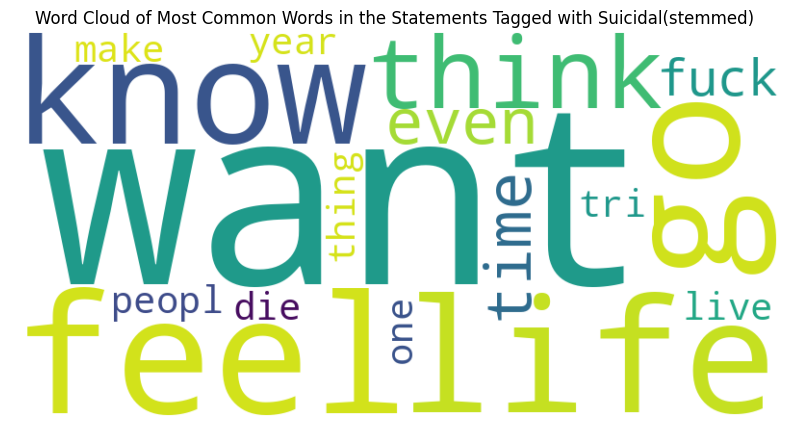

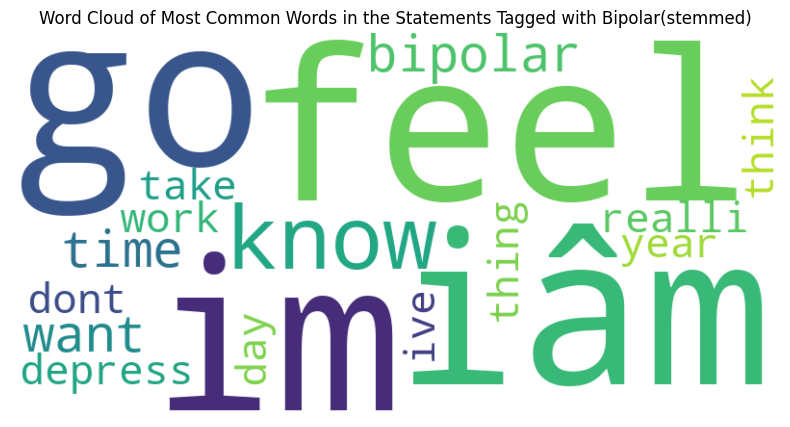

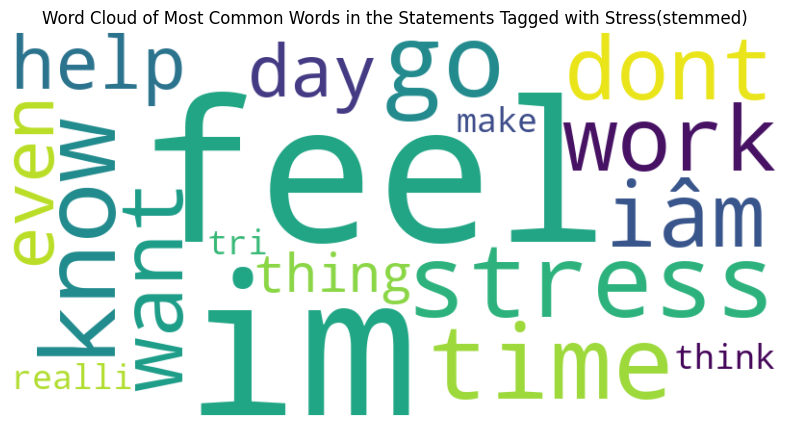

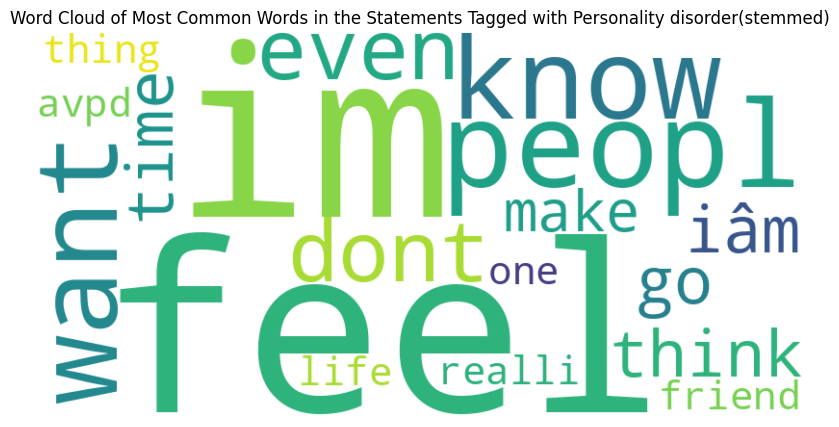

In [ ]:
status_list = ['Anxiety','Suicidal','Bipolar','Stress','Personality disorder']
for status in status_list:
  createWordCloud(data,status)

When comparing the most common words used by individuals tagged as "normal" to those tagged with "depression," we find that words like "like," "want," "time," "know," "people," "year," "think," and "go" are frequently used across both groups. This pattern is also similar in all other groups. However, examining the words unique to each class could provide deeper insights.

# Unique Words Across Different Classes

In [ ]:
lemmatized_or_stemmed = 'stemmed'
all_words = set([word for row in data[lemmatized_or_stemmed] for word in row])
def unique_words(status,all_words,most_common_num):
  """
  status: desired tag of mental illness
  all_words: set of all words in the corpus
  most_common_num: number of most common words to return
  """
  # set of all words that do not belong to the tagged status
  rest_of_words = set([word for row in data.loc[data['status']!=status,lemmatized_or_stemmed] for word in row])
  # set of all words that belong to the tagged status
  unique_words = all_words.difference(rest_of_words)
  # The words and their frequency that belongs to the tagged status uniquely
  Freq_unique_words = Counter([word for row in data.loc[data['status']==status,lemmatized_or_stemmed] for word in row if word in unique_words])
  df_unique_words = pd.DataFrame(Freq_unique_words.most_common(most_common_num),columns=['words','count']).reset_index(drop=True)
  return df_unique_words


## Unique Words in Normal-Tagged Data

In [ ]:
df_unique_words_normal = unique_words('Normal',all_words,30)
print("The top 10 unique words in Normal-Tagged posts are:")
df_unique_words_normal.style.background_gradient(cmap='Blues')

The top 10 unique words in Normal-Tagged posts are:


,words,count
0,twitpic,34
1,rtlike,26
2,ãâ,25
3,nct,24
4,tinyurl,24
5,lebaran,20
6,nctzen,19
7,ãââãâ,19
8,awww,19
9,kal,15


When we check these unique words we see that there are words that are not meaningful. If we further explore them in raw data:

In [ ]:
for statement in data.loc[data['lemmatized'].apply(lambda x:'twitpic' in x),'statement']:
    print(f"S: {statement}\n")

S: switchfoot http twitpic com y zl awww that s a bummer you shoulda got david carr of third day to do it d

S: why won t you show my location http twitpic com y e

S: http twitpic com y wr according to my bro our new puppy had a poo fight and wa covered in poop picture stolen from him

S: http twitpic com y yi i love you buck

S: http twitpic com y e i wan na wear my doc marten out haven t worn them since december

S: http twitpic com y e cant see the flower falling i dont have a camera just my cellphone

S: http twitpic com y cf filled with curry the true indian in me is coming out

S: danielledeleasa http twitpic com y pe i hate b allergic i want a puppy soo bad that i ve already thought some cool name

S: white trash v u we were outnumbered http twitpic com y jp

S: why can t i sleep like her http twitpic com y ty

S: sodding m http twitpic com y y0

S: i ve finally given in now at malaysian restaurant waiting for nasi lemak and teh tarik mereka tak faham bm http twitpic com y bh



"Upon examining the unique words, we see that some, like 'rtlike' and 'twitpic,' are not meaningful. The term 'twitpic' should have been removed during the cleaning process, but it was not identified because it was not in URL format. To clean these words we will save them and apply cleaning process one more time."

#### Words to be cleaned in Normal-Tagged data

In [ ]:
# Words that might be cleaned:
word_to_clean = []
for word in df_unique_words_normal['words']:
  if word not in ['indonesia']:
    word_to_clean.append(word)

word_to_clean.extend(['http','com'])

## Unique Words in Depression-Tagged Data

In [ ]:
df_unique_words_depression = unique_words('Depression',all_words,30)
print("The top 20 unique words in Depression-Tagged posts are:")
df_unique_words_depression.style.background_gradient(cmap='Oranges')

The top 20 unique words in Depression-Tagged posts are:


,words,count
0,mizzzidc,51
1,theekween,45
2,thelmasherb,44
3,mentalhealth,28
4,pogba,24
5,mourinho,16
6,fuckfuckfuck,15
7,wort,13
8,tto,12
9,healthgrad,11


#### Words to be cleaned in Depression-Tagged data




In [ ]:
for word in df_unique_words_depression['words']:
  if word not in ['amnesia','inertia','mentalhealth','proxim','wort','conscienti','curch','sso','buprenorphin','soylent']:
    word_to_clean.append(word)

## Unique Words in Anxiety-Tagged Data

In [ ]:
df_unique_words_anxiety = unique_words('Anxiety',all_words,15)
print("The top 10 unique words in Anxiety-Tagged posts are:")
df_unique_words_anxiety.style.background_gradient(cmap='Greens')

The top 10 unique words in Anxiety-Tagged posts are:


,words,count
0,hantaviru,25
1,asbesto,12
2,mammogram,11
3,esophag,10
4,platelet,9
5,lymphnod,9
6,thermomet,9
7,parkinsonâ,9
8,avocado,8
9,mastoid,8


## Unique Words in Suicidal-Tagged Data

In [ ]:
df_unique_words_suicidal = unique_words('Suicidal',all_words,10)
print("The top 10 unique words in Suicidal-Tagged posts are:")
df_unique_words_suicidal.style.background_gradient(cmap='Greens')

The top 10 unique words in Suicidal-Tagged posts are:


,words,count
0,wallsim,128
1,thath,15
2,gangsta,12
3,guild,10
4,ich,9
5,cuzz,8
6,aãââ,8
7,iãââv,8
8,cst,7
9,tãââ,7


#### Words to be cleaned in Suicidal-Tagged data

In [ ]:
for statement in data.loc[data['stemmed'].apply(lambda x:'wallsim' in x),'statement']:
    print(f"S: {statement}\n")

S: I am LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLS I am LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLS I am LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLS I am LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLS I am LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLS I am LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLS I am LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLS I am LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLSI'M LIVING IN YOUR WALLS I am LIVING IN YOUR W

We can drop that row. It is lyric from a song.

In [ ]:
data.drop(data.loc[data['stemmed'].apply(lambda x:'wallsim' in x)].index, inplace=True)

In [ ]:
# Reset the index
data.reset_index(drop=True, inplace=True)

More words to be cleaned from the corpus:

In [ ]:
word_to_clean.extend(['thath','gangsta','aãââ','tãââ','iãââv'])

'ich' is in most common words. We eliminated different languages before but this doesn't seem to be eliminated. If we print the statements including 'ich':

In [ ]:
for statement in data.loc[data['stemmed'].apply(lambda x:'ich' in x),'statement']:
    print(f"S: {statement}\n")

S: Ich will mir das Leben nehmen hat wer ein paar Tipps? Kein plan ob das die richtige Gruppe dafr ist ich verzweifelt und wei nicht mehr weiter I wann kill my self does anyone have any Tipps? I know that this is not the right group for this but i do not care (Sry my Englisch is bad asf) Suicide

S: Ich kann nicht mehr... Ich will nicht mehr...Ich kann weder richtig essen noch schlafen... Ich bin seit langem auf der Suche nach einem Weg mir das Leben zu nehmen ohne Schmerzen dabei zu haben. Ich wei dass es in der Schweiz fr gutes Geld mglich ist sich einschlfern zu lassen, allerdings bin ich nicht reich genug dafr.I am Internet findet man auer nett gemeinter Hilfe von Prventionsteams nichts darber wie man den ganzen schei am besten und schmerzfreisten ber die Bhne bringen kann.Kommentare wie zb: "bade mit deinem Toaster", "Ritz dich" oder "Trink Rohrreiniger" knnt ihr euch sparen da ich schmerzen mglichst vermeiden will.Ebenso knnt ihr Kommentare wie "reden hilft" weg lassen..Ich will 

There are two rows with statements that are half in German and half in English. We will clean the German parts and keep the English parts.

#### Cleaning German parts of the statements

In [ ]:
data.drop(data.loc[data['stemmed'].apply(lambda x:'ich' in x)].index, inplace=True)

In [ ]:
# Reindex
data = data.reset_index(drop=True)

In [ ]:
# add_english_parts
dict_rows = {'statement':['I wann kill my self does anyone have any Tipps? I know that this is not the right group for this but i do not care (Sry my Englisch is bad asf) Suicide',
                          'I cannot anymore ... I do not want to anymore ...I can neither eat nor sleep ...I have been looking for a way to kill myself without pain for a long time.I know that it is possible to be put to sleep in Switzerland for a lot of money, but I am not rich enough for it.Apart from nicely meant help from prevention teams, there is nothing on the Internet about how to do all this shit in the best and most pain-free manner.You can save yourself comments such as: "bathe with your toaster", "cut yourself" or "drink pipe cleaner" because I want to avoid pain as much as possible.You can also leave out comments like "talking helps".I do not want to talk anymore, I want to end it it is enough.'],
             'status':['Suicidal','Suicidal']}
data_two_rows = pd.DataFrame(dict_rows)

In [ ]:
data_two_rows = clean_and_preprocess(data_two_rows)

In [ ]:
data_two_rows['word_count'] = data_two_rows['statement'].apply(lambda x:len(x.split(' ')))
data_two_rows['lemmetized_word_counts'] = data['lemmatized'].apply(len)

In [ ]:
# concatenate new cleaned rows to data
data = pd.concat([data, data_two_rows], ignore_index=True)

## Unique Words in Bipolar-Tagged Data

In [ ]:
df_unique_words_bipolar = unique_words('Bipolar',all_words,10)
print("The top 10 unique words in Bipolar-Tagged posts are:")
df_unique_words_bipolar.style.background_gradient(cmap='Greens')

The top 10 unique words in Bipolar-Tagged posts are:


,words,count
0,pdoc,93
1,vraylar,34
2,geodon,29
3,saphri,17
4,bpii,15
5,zeebi,15
6,rbipolar,14
7,lamotragin,13
8,manichypoman,10
9,bipolarâ,8


These words are drug names or terms related to bipolar disorder. We will keep them

## Unique Words in Stress-Tagged Data

In [ ]:
df_unique_words_stress = unique_words('Stress',all_words,10)
print("The top 10 unique words in Stress-Tagged posts are:")
df_unique_words_stress.style.background_gradient(cmap='Greens')

The top 10 unique words in Stress-Tagged posts are:


,words,count
0,hz,12
1,endocannabinoid,8
2,binaur,7
3,nyu,6
4,langon,6
5,mbsr,6
6,xëul,6
7,healthelig,4
8,dsssocial,3
9,bootsi,3


#### Words to be cleaned in Stress-Tagged data


In [ ]:
word_to_clean.extend(['xëul', 'healthelig','dsssocial','bootsi'])

## Unique Words in Personality disorder-Tagged Data

In [ ]:
df_unique_words_per_dis = unique_words('Personality disorder',all_words,10)
print("The top 10 unique words in Personality disorder-Tagged posts are:")
df_unique_words_per_dis.style.background_gradient(cmap='Greens')

The top 10 unique words in Personality disorder-Tagged posts are:


,words,count
0,hikikomori,5
1,âbest,4
2,avpder,3
3,itview,3
4,mushishi,3
5,hispanicpuerto,3
6,stevi,3
7,failurecoward,3
8,wayview,3
9,skillsâ,3


#### Words to be cleaned in Personality Disorder-Tagged data

In [ ]:
for word in df_unique_words_per_dis['words']:
  word_to_clean.append(word)

Words to be cleaned:

In [ ]:
for word in word_to_clean:
  print(word)

twitpic
rtlike
ãâ
nct
tinyurl
lebaran
nctzen
ãââãâ
awww
kal
wayzenni
mileycyru
mutualan
itun
tommcfli
kutner
ningn
jonathanrknight
cantu
plurk
vlive
ma
regent
jakarta
stephenkruis
wkwk
jaemin
jisung
âãåëâ
http
com
mizzzidc
theekween
thelmasherb
pogba
mourinho
fuckfuckfuck
tto
healthgrad
ththey
maximu
thelmaherb
onso
hana
mirag
covidi
unfuck
beleiv
anywayhurt
bv
waterpm
thath
gangsta
aãââ
tãââ
iãââv
xëul
healthelig
dsssocial
bootsi
hikikomori
âbest
avpder
itview
mushishi
hispanicpuerto
stevi
failurecoward
wayview
skillsâ


## Cleaning these words from the Stemmed Column

In [ ]:
data['stemmed'] = data['stemmed'].apply(lambda x: list(filter(lambda word: word not in word_to_clean, x)))

# Cosine Similarity Using Word2Vec

Here when preprocessing we have to keep the words in sentences together in each statement since the context is important for embedding. Preprocessing of the sentences is done below.

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize

# Given a sentence removes the words that are in words_to_clean
def word_removal(sentence_words, words_to_clean):
    # Create a new list of words excluding the ones to be cleaned
    filtered_words = [word for word in sentence_words if word not in words_to_clean]
    return filtered_words

# Preprocess text: tokenize into sentences, then words
def preprocess_sentences(text):
    # Tokenize into sentences
    sentences = sent_tokenize(text)
    # Preprocess each sentence
    # clean sentences using text_clean function defined above
    cleaned_sentences = [text_clean(sentence) for sentence in sentences]
    # remove the words in the list words_to_clean defined above with the function word_removal
    cleaned_sentences = [' '.join(word_removal(word_tokenize(sentence), word_to_clean)) for sentence in cleaned_sentences]
    tokenized_sentences = [text_preprocess(sentence)['stemmed'] for sentence in cleaned_sentences]
    return tokenized_sentences

# Apply preprocessing to each statement in the DataFrame
processed_statements = [preprocess_sentences(statement) for statement in data['statement']]

# Flatten the list of lists to create a union of all sentences
sentences = [sentence for statement in processed_statements for sentence in statement]

# 2. Train Word2Vec model
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, sg=0)


In [ ]:
data['sentence_stemmed'] = processed_statements

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def create_corr_heatmap(model, desired_words,show_corr_values=False):
  word_vectors = {}
  for word in desired_words:
    if word in model.wv:
            word_vectors[word] = model.wv[word]
    else:
      print(f"'{word}' is not in the model's vocabulary.")
  # Create a matrix of word vectors
  vector_matrix = np.array([word_vectors[word] for word in desired_words if word in word_vectors])

  # Compute cosine similarity matrix
  similarity_matrix = cosine_similarity(vector_matrix)

  # Create a DataFrame for the similarity matrix
  similarity_df = pd.DataFrame(similarity_matrix, index=[word for word in desired_words if word in word_vectors],
                             columns=[word for word in desired_words if word in word_vectors])

  # Plot heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(similarity_df, annot=show_corr_values, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title('Cosine Similarity Between Most Common Words')
  plt.show()



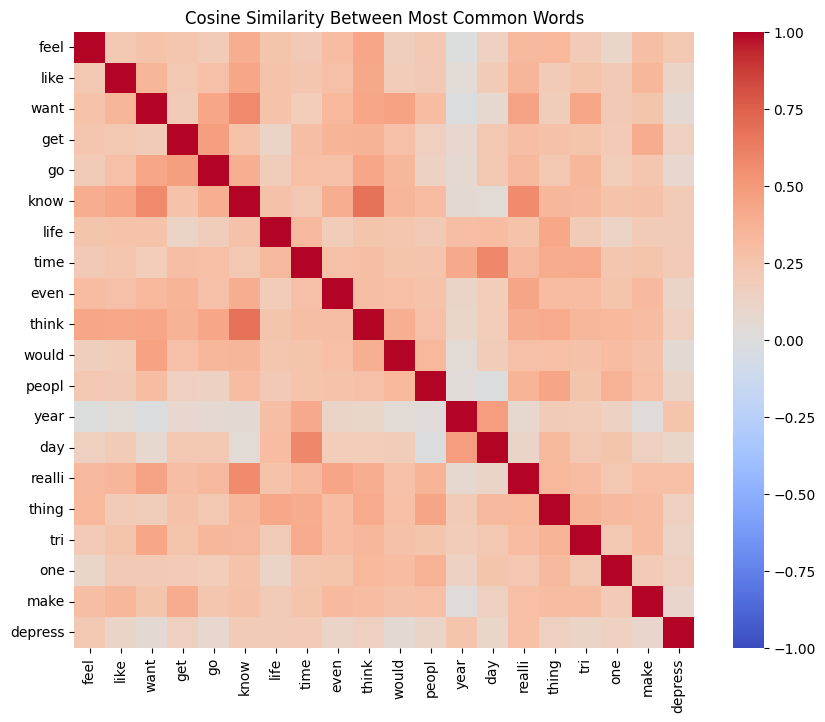

In [ ]:
common_words = df_words['words']
create_corr_heatmap(model, common_words)

### Some Selected Words

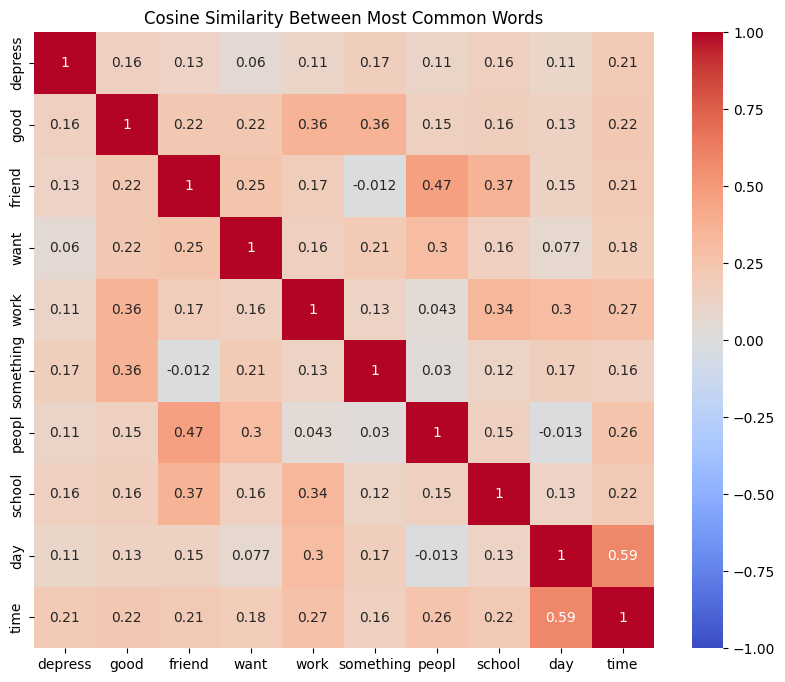

In [ ]:
selected_words = ['depress', 'good',  'friend', 'want', 'work','something','peopl','school','day','time']
create_corr_heatmap(model, selected_words,show_corr_values=True)

If we check the values, we observe that 'day' and 'time' has a correlation of 0.61 which is moderate positive correlation. The words 'good' and 'depress' has very low correlation.

In [ ]:
# Save the trained Word2Vec model
model.save("word2vec_model.model")

In [ ]:
# Load the word vectors
model = Word2Vec.load("word2vec_model.model")

In [ ]:
# save the data
import time
# Define chunk size
chunk_size = 500

# Open the file for writing
with open('/content/data_clean.csv', 'w', encoding='latin1') as f:
#with open('/content/drive/My Drive/Colab Notebooks/Mental Health Sensitivity Analysis/data_clean.csv', 'w', encoding='latin1') as f:
    # Write the header for the first chunk
    data.iloc[0:chunk_size].to_csv(f, header=True, index=False)

    # Append the rest of the chunks
    for i in range(chunk_size, len(data), chunk_size):
        data.iloc[i:i + chunk_size].to_csv(f, header=False, index=False)
        # Pause for 5 seconds
        time.sleep(1)

In [ ]:
# load the data

# Define chunk size
chunk_size = 5000  # Adjust the chunk size as needed

# X_train
chunks = []

# Read in chunks
try:
    #for chunk in pd.read_csv('/content/drive/My Drive/Colab Notebooks/Mental Health Sensitivity Analysis/data_clean.csv',
    for chunk in pd.read_csv('/content/data_clean.csv',
                             chunksize=chunk_size, encoding='latin1',
                             engine='python'):
        chunks.append(chunk)
        time.sleep(1)

    # Concatenate all chunks into a single DataFrame
    data_reload = pd.concat(chunks)

except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
data.shape

(48249, 8)

In [ ]:
data_reload.shape

(48249, 8)

In [ ]:
data_reload.isna().sum()

,0
statement,0
status,0
word_count,0
statement_cleaned,0
stemmed,0
lemmatized,0
lemmetized_word_counts,0
sentence_stemmed,0


The cleaned data can be found in this link: https://drive.google.com/file/d/1op_WhMFAcz_Y53icV1ktnXCwZjvZp9cI/view?usp=sharing